In [312]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
# from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from ast import literal_eval

BASE_PATH = "C:/Users/MrLinh/Downloads/movie_reccommender/model"
PATH_TO_IMDB = f"{BASE_PATH}/movies_data/imdb_folder"
PATH_TO_RATING = f"{PATH_TO_IMDB}/ratings_small.csv"

PATH_TO_MLENS = f""

PATH_TO_FEATURE_STORE = f"{BASE_PATH}/feature_store_new.csv"
PATH_TO_VECTORIZED_TEXT = f"{BASE_PATH}/vectorized_text.pickle"
PATH_TO_COSINE_MATRIX = f"{BASE_PATH}/cosine_matrix.pickle"
PATH_TO_SVD = f"{BASE_PATH}/svd_matrix.pickle"
PATH_TO_VECTORIZER = f"{BASE_PATH}/vectorizer.pickle"

"""
ToDos:

in model_serving will need the full dataframe and the pickle file model

First, request stores some movie_id => 1. filter those in the same genres with the highest scores, use explode here 
3. add = filter out the top N based on text similarities with other movies
- dimensionality reduction of overview and soup
- plot of variance decomposition
- cosine similaritity
- check for duplicates
2. collaborative filtering: within this smaller pool, based on rating with other movies
- create rating matrix
- weighted mean
- reverse mapping between index and title


"""


'\nToDos:\n\nin model_serving will need the full dataframe and the pickle file model\n\nFirst, request stores some movie_id => 1. filter those in the same genres with the highest scores, use explode here \n3. add = filter out the top N based on text similarities with other movies\n- dimensionality reduction of overview and soup\n- plot of variance decomposition\n- cosine similaritity\n- check for duplicates\n2. collaborative filtering: within this smaller pool, based on rating with other movies\n- create rating matrix\n- weighted mean\n- reverse mapping between index and title\n\n\n'

In [2]:
FEATURE_STORE = pd.read_csv(PATH_TO_FEATURE_STORE)
FEATURE_STORE["overview"].fillna('',inplace=True)
FEATURE_STORE["soup"].fillna('',inplace=True)
# TARGETS = 
COVARIATES = ["overview", "soup"]

X = FEATURE_STORE[COVARIATES]

In [2]:
X["text_data"] = X["overview"] + X["soup"]

C:\Users\MrLinh\AppData\Local\Temp\ipykernel_15968\3326728385.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["text_data"] = X["overview"] + X["soup"]


In [3]:
vectorizer = TfidfVectorizer()
vectorizer = vectorizer.fit_transform(X["text_data"])

In [27]:
# with open(PATH_TO_VECTORIZER, "wb") as file:
#     pickle.dump(vectorizer, file)

In [5]:
svd = TruncatedSVD(n_components=1000)
svd_matrix = svd.fit_transform(vectorizer)

In [28]:
# Save the model object, not the np array!!!
# with open(PATH_TO_SVD, "wb") as file:
#     pickle.dump(svd_matrix, file)

In [378]:
with open(PATH_TO_SVD,"rb") as file:
    svd = pickle.load(file)

In [18]:
svd_matrix.shape

(9384, 1000)

In [14]:
svd.explained_variance_ratio_.ravel()[svd.explained_variance_ratio_.ravel().argmax()]

0.004664543885765755

In [7]:
svd_matrix.shape

(9384, 1000)

In [19]:
cosine_matrix = cosine_similarity(svd_matrix)

In [29]:
# with open(PATH_TO_COSINE_MATRIX, "wb") as file:
#     pickle.dump(cosine_matrix, file)

In [21]:
cosine_matrix.shape

(9384, 9384)

In [23]:
cosine_matrix_df = pd.DataFrame(cosine_matrix,index=FEATURE_STORE.id, columns=FEATURE_STORE.id)

In [10]:
FEATURE_STORE[FEATURE_STORE.id.apply(lambda x: x in [44918,62])]

,Unnamed: 0,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,...,spoken_languages,status,tagline,title,video,vote_average,vote_count,keywords,score,soup
443,903,False,"{'id': 4438, 'name': 'The Space Odyssey Series...",10500000,"['sciencefiction', 'mystery', 'adventure']",NaN,62,tt0062622,en,2001: A Space Odyssey,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,An epic drama of adventure and exploration,2001: A Space Odyssey,False,7.9,3075.0,"['moon', 'jupiter', 'artificialintelligence']",7.875789,moon jupiter artificialintelligencesciencefict...
9381,46364,False,NaN,0,"['action', 'adventure', 'thriller']",NaN,44918,tt1640571,en,Titanic II,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"100 years later, lightning strikes twice",Titanic 2,False,3.4,55.0,['suspense'],4.792916,suspenseaction adventure thriller


In [ ]:
"""in model_serving will need the full dataframe and the pickle file model

First, request stores some movie_id => 1. filter those in the same genres with the highest scores, use explode here 
3. add = filter out the top N based on text similarities with other movies
- dimensionality reduction of overview and soup
- plot of variance decomposition
- cosine similaritity
- check for duplicates
2. collaborative filtering: within this smaller pool, based on rating with other movies
- create rating matrix
- weighted mean
- reverse mapping between index and title"""

In [11]:
FEATURE_STORE["genres"] = FEATURE_STORE["genres"].apply(literal_eval)
# always do this after loading csv file

In [239]:
FEATURE_STORE["release_date"] = FEATURE_STORE["release_date"].apply(lambda x: int(x.split('-')[0]) if isinstance(x,str) else 0)

In [246]:
final_df = FEATURE_STORE.explode("genres")

In [240]:
min_year = FEATURE_STORE["release_date"].min()
final_df = final_df[final_df["release_date"] >= min_year]
# need year condition to diversify recommendations

In [245]:
FEATURE_STORE["release_date"].min()

0

In [247]:
final_df["release_date"].min()

0

In [18]:
final_df.shape

(15447, 28)

In [24]:
# load cosine simil matrix
with open(PATH_TO_COSINE_MATRIX, "rb") as file:
    simil_matrix = pickle.load(file)

In [98]:
FEATURE_STORE.columns

Index(['Unnamed: 0', 'adult', 'belongs_to_collection', 'budget', 'genres',
       'homepage', 'id', 'imdb_id', 'original_language', 'original_title',
       'overview', 'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'keywords', 'score', 'soup'],
      dtype='object')

In [29]:
simil_df = pd.DataFrame(simil_matrix,columns=FEATURE_STORE["id"],index=FEATURE_STORE["id"])

In [30]:
simil_df.head()

id,862,8844,15602,11862,949,11860,9091,710,9087,12110,...,68637,451955,54559,417320,277839,430365,248705,44918,455661,14008
id,,,,,,,,,,,,,,,,,,,,,
862,1.000000,0.065037,0.062389,0.052147,0.046417,0.021350,0.042294,0.036127,0.003106,0.049896,...,0.050494,0.035304,0.033430,0.025476,0.049779,0.029543,0.046412,0.038924,0.084286,0.052921
8844,0.065037,1.000000,0.110556,0.049448,0.141412,0.019962,0.280361,0.021288,0.024174,0.080014,...,0.052559,0.010041,0.046738,0.076490,0.104255,0.069554,0.100297,0.074023,0.016321,0.066702
15602,0.062389,0.110556,1.000000,0.114267,0.031412,-0.003700,0.015533,0.049726,0.054819,0.071560,...,0.068594,0.081928,0.048830,0.093769,0.111571,0.043641,0.049751,0.048130,0.024976,0.178935
11862,0.052147,0.049448,0.114267,1.000000,0.050149,0.085018,0.053000,0.055169,0.105118,0.055736,...,0.073401,0.089235,0.049595,0.154873,0.084230,0.108756,0.056976,0.066366,0.064085,0.082096
949,0.046417,0.141412,0.031412,0.050149,1.000000,0.000833,0.101006,0.050767,0.023156,0.034314,...,0.013253,0.028615,0.001148,0.032517,0.100615,0.082374,0.081001,0.096766,0.018148,0.036058


In [375]:
def movie_rec(movie_ids):
    def genres_extract(): # return 10
        print(FEATURE_STORE[FEATURE_STORE["id"].apply(lambda x: x in movie_ids)][["id","title","genres","score"]])
        genres_list = []
        for id in movie_ids:
            genres_list += (final_df[final_df["id"] == id]["genres"].to_list())

        filtered_df = final_df[final_df["genres"].apply(lambda x: x in set(genres_list))].drop_duplicates(subset="id")
        print(filtered_df["genres"].values)
        return filtered_df.sort_values(by="score",ascending=False)[:10]["id"]
    def simil_extract(): # return 10
        simil_id = []
        for id in movie_ids:
            simil_id += simil_df[id].sort_values(ascending=False).index.to_list()[:5]
        
        reduced_df = final_df.drop_duplicates(subset="id")
        reduced_id =  reduced_df[reduced_df["id"].apply(lambda x: x in simil_id)].sort_values(by="score",ascending=False)["id"]
        return reduced_id
       
    id1 = genres_extract().to_list()
    id2 = simil_extract().to_list()
    id_final = id1 + id2
    return FEATURE_STORE[FEATURE_STORE["id"].apply(lambda x: x in id_final)][["id","title","genres","release_date","score"]].sample(frac=1)
    
movie_rec(np.random.choice(final_df.id.unique(),size=2))

          id         title                               genres     score
5772   20526  TRON: Legacy  [adventure, action, sciencefiction]  6.300939
9047  402298        Denial                     [drama, history]  6.466492
['adventure' 'action' 'action' ... 'drama' 'action' 'action']


,id,title,genres,release_date,score
4634,1858,Transformers,"[adventure, sciencefiction, action]",2007,6.597132
7745,249688,The End of the Tour,[drama],2015,7.121480
8795,311667,Manhattan Night,"[drama, mystery, thriller]",2016,6.176605
1166,637,Life Is Beautiful,"[comedy, drama]",1997,8.274205
9047,402298,Denial,"[drama, history]",2016,6.466492
1042,97,Tron,"[sciencefiction, action, adventure]",1982,6.584417
1521,550,Fight Club,[drama],1999,8.290209
7278,244786,Whiplash,[drama],2014,8.278478
5772,20526,TRON: Legacy,"[adventure, action, sciencefiction]",2010,6.300939
2951,290,Barton Fink,"[comedy, drama]",1991,7.297522


Text(0.5, 1.0, 'Distribution of movies by release year - highly skewed')

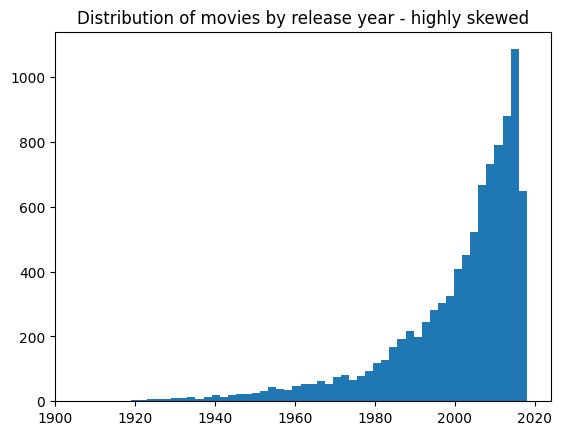

In [376]:
plt.hist(FEATURE_STORE["release_date"],bins=1000)
plt.xlim(1900,2024)
plt.title("Distribution of movies by release year - highly skewed")